D:\Anaconda\anaconda\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


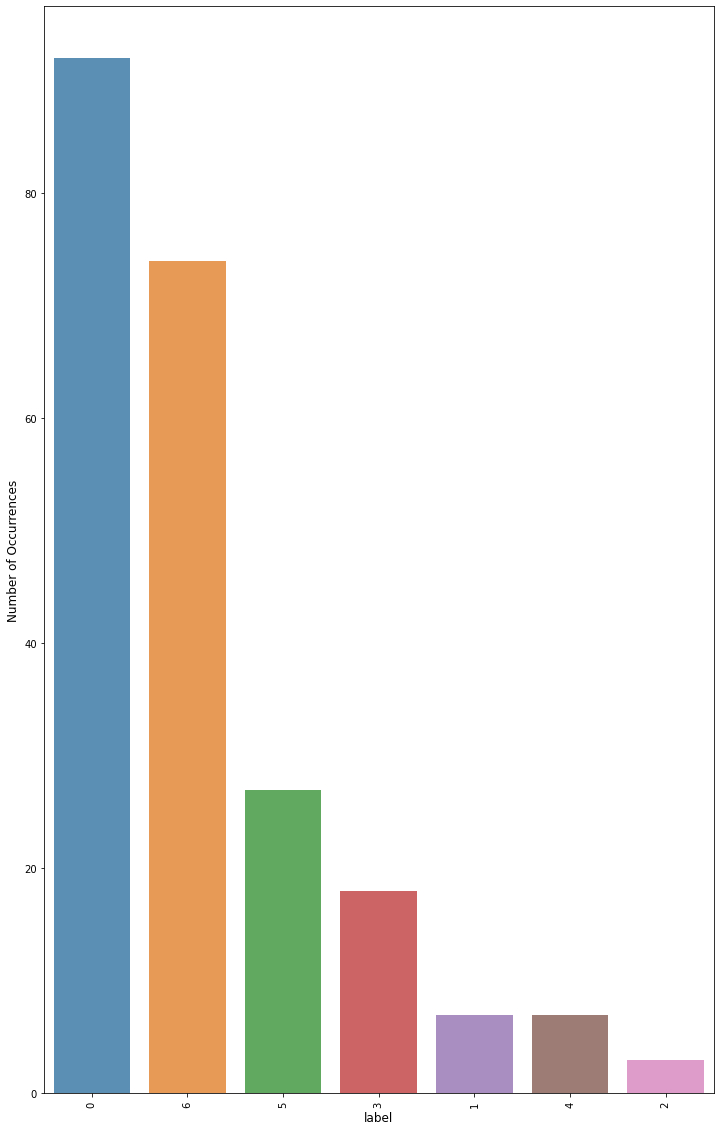

In [332]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk import re
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import Doc2Vec
from tqdm import tqdm
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer

'''
sourse_data = pd.read_excel('D:/SURF/tradition_medicine/Data/new_sheet.xlsx', sheet_name='Sheet1', usecols=[0,19,20,21,22,23,24,25,26,27,28,29])
data = sourse_data.to_csv('D:/SURF/tradition_medicine/Data/data.csv', encoding='utf-8')
'''
rd_data = pd.read_csv('D:/SURF/tradition_medicine/Data/data.csv', header=0, index_col=0)
df = pd.DataFrame(rd_data)

df["label1"] = df.iloc[:, lambda df: [1, 2, 3, 4, 5, 6, 7]].values.tolist() #选择dataframe的1234567列
df["label"] = df["label1"].astype(str)
#df["label"] = df.loc[:, ['HumanInt', 'Responsi', 'Morality', 'EcoCons', 'Conflict', 'Factual', 'Leadersh']]
df["corpus1"] = df.loc[:, ['title', 'content']].values.tolist()
df["corpus"] = df["corpus1"].astype(str)
#print(df)

result_data = df[['News item', 'corpus', 'label']]
#print(result_data)
#result_data = pd.DataFrame(columns=['News item', 'corpus', 'label'])
#print(result_data.shape)  (253, 10)

#1234567: ['HumanInt', 'Responsi', 'Morality', 'EcoCons', 'Conflict', 'Factual', 'Leadersh']
result_data.loc[:,'label'] = result_data['label'].replace('[1, 0, 0, 0, 0, 0, 0]', '0') \
    .replace('[0, 1, 0, 0, 0, 0, 0]', '1') \
    .replace('[0, 0, 1, 0, 0, 0, 0]', '2') \
    .replace('[0, 0, 0, 1, 0, 0, 0]', '3') \
    .replace('[0, 0, 0, 0, 1, 0, 0]', '4') \
    .replace('[0, 0, 0, 0, 0, 1, 0]', '5') \
    .replace('[0, 0, 0, 0, 0, 0, 1]', '6')

result_data['label'].tolist()

#print(type(result_data['label']))

result_data = result_data[result_data['label'].isin(['0', '1', '2', '3', '4', '5', '6'])]

#result_data.to_csv('D:/SURF/tradition_medicine/Data/data.csv', index=False)
#print(result_data.head()
#print(result_data.replace('[1, 0, 0, 0, 0, 0, 0]', 'HumanInt'))

result_data.index = range(228)
result_data['corpus'].apply(lambda x: len(str(x).split(' '))).sum()

def plot_doc_len(df):
    plt.figure(figsize=(12, 20))
    sns.barplot(df.index, df.values, alpha=0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('label', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

df = result_data['label'].value_counts()
plot_doc_len(df)

In [333]:
#数据预处理
from string import punctuation
import re
class rule:
    # 正则表达式过滤特殊符号用空格符占位
    pat_letter =  re.compile('[{}]'.format(re.escape(punctuation))) 
    #清洗数字
    pat_num = re.compile("[\d+]".format(re.escape(punctuation)))
    # 还原常见缩写单词
    pat_is = re.compile("(it|he|she|that|this|there|here)(\'s)", re.I)
    pat_s = re.compile("([a-zA-Z])(\'s)")  # 处理类似于这样的缩写today’s
    pat_not = re.compile("([a-zA-Z])(n\'t)")  # not的缩写
    pat_would = re.compile("([a-zA-Z])(\'d)")  # would的缩写
    pat_will = re.compile("([a-zA-Z])(\'ll)")  # will的缩写
    pat_am = re.compile("([I|i])(\'m)")  # am的缩写
    pat_are = re.compile("([a-zA-Z])(\'re)")  # are的缩写
    pat_ve = re.compile("([a-zA-Z])(\'ve)")  # have的缩写


def replace_abbreviations(text):
    new_text = text
    new_text = rule.pat_letter.sub(' ', new_text).strip().lower()
    new_text = rule.pat_num.sub(' ', new_text).strip()
    new_text = rule.pat_is.sub(r"\1 is", new_text)#其中\1是匹配到的第一个group
    new_text = rule.pat_s.sub(r"\1 ", new_text)
    new_text = rule.pat_not.sub(r"\1 not", new_text)
    new_text = rule.pat_would.sub(r"\1 would", new_text)
    new_text = rule.pat_will.sub(r"\1 will", new_text)
    new_text = rule.pat_am.sub(r"\1 am", new_text)
    new_text = rule.pat_are.sub(r"\1 are", new_text)
    new_text = rule.pat_ve.sub(r"\1 have", new_text)
    new_text = new_text.replace('\'', ' ')
    return new_text


# 停用词列表
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

# 加载停用词
stopwords = stopwordslist("D:/surf/tradition_medicine/Data/stop_words.txt")

# 正则清洗
result_data['clean_review'] = result_data['corpus'].apply(replace_abbreviations)

# 分词，并过滤停用词
result_data['cut_review'] = result_data['clean_review'].apply(lambda x: [w for w in list(word_tokenize(x)) if w not in stopwords])


D:\Anaconda\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


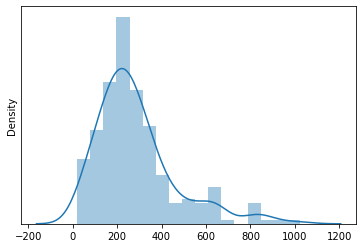

,News item,corpus,label,clean_review,cut_review,doc_length
0,1001.0,['AMERICAN IN PEKING DOUBTS ACUPUNCTURE AS TRE...,0,american in peking doubts acupuncture as treat...,"[american, peking, doubts, acupuncture, treatm...",416
1,1002.0,['Chinese Immigrants Say Clinics Fill a Need f...,0,chinese immigrants say clinics fill a need for...,"[chinese, immigrants, clinics, fill, inexpensi...",265
2,1003.0,['Chinese Medicine Proves Itself Where Western...,6,chinese medicine proves itself where western m...,"[chinese, medicine, proves, western, medicine,...",209
3,1004.0,"['BEYOND ACUPUNCTURE', ""ENCOUNTERS WITH QI Exp...",6,beyond acupuncture encounters with qi explo...,"[acupuncture, encounters, qi, exploring, chine...",285
4,1005.0,"['A Chinese Art, In the Context Of the West', ...",6,a chinese art in the context of the west a...,"[chinese, art, context, west, acupuncture, tra...",89


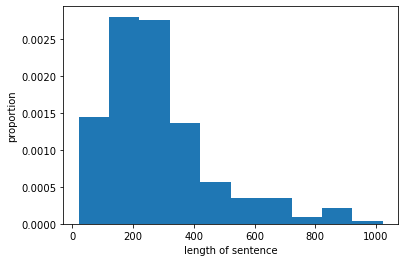

In [337]:
#看看句子长度分布

# 在数据中添加新的文档长度列, 每个元素的值都是对应的corpus列的长度
result_data["doc_length"] = list(map(lambda x: len(x), result_data["cut_review"]))
doc_length = result_data["doc_length"].tolist()

# 绘制dist长度分布图
sns.distplot(doc_length)
 
# 主要关注dist长度分布横坐标, 不需要绘制纵坐标
plt.yticks([])
plt.show()

#直方图
plt.hist(doc_length,bins=None,range=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, density=True,stacked=False)

plt.xlabel("length of sentence")
plt.ylabel("proportion")

result_data.head()

In [338]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [339]:
# 创建训练集和测试集
train, test = train_test_split(result_data, test_size=0.2, random_state=42, stratify= result_data['label'])
# 创建标签化文档
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['label']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['label']]), axis=1)

In [340]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=40)

model.build_vocab(train_tagged)

model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)

2022-08-05 23:09:29,531 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d300,n5,w5,mc2,s0.001,t3>', 'datetime': '2022-08-05T23:09:29.531319', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
2022-08-05 23:09:29,576 : INFO : collecting all words and their counts
2022-08-05 23:09:29,577 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-05 23:09:29,587 : INFO : collected 9320 word types and 7 unique tags from a corpus of 182 examples and 49515 words
2022-08-05 23:09:29,588 : INFO : Creating a fresh vocabulary
2022-08-05 23:09:29,613 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 4876 unique words (52.32% of original 9320, drops 4444)', 'datetime': '2022-08-05T23:09:29.613545', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0

In [341]:
from sklearn.feature_extraction.text import CountVectorizer

cut_review = test['cut_review'].tolist()
corpus =  [str(i) for i in cut_review]
vectorizer = CountVectorizer()
a = []
a.append(corpus[0])
X = vectorizer.fit_transform(a)
print(X.shape)
word_list = vectorizer.get_feature_names()
vector = model.infer_vector(word_list)


print(type(vector))
print(vector.shape)

whole = []
for each in vector:
     temp = []
     temp.append(each)
     whole.append(temp)

final = np.array(whole)
final_1 = final.transpose()
print(final_1.shape)
print(type(final_1))

files_vectors = []
for each in corpus:
  files_vectors.append(final_1)   

print(len(files_vectors))
#print(files_vectors)


(1, 226)
<class 'numpy.ndarray'>
(300,)
(1, 300)
<class 'numpy.ndarray'>
46


In [342]:
result = np.array(files_vectors)
print(result.shape)

(46, 1, 300)


In [343]:
from sklearn.datasets._base import Bunch
result = Bunch()
result.data = np.array(files_vectors).reshape(46,1*300) 
result.target = np.array(test['label'].astype(dtype=int).tolist())
result.target_names =np.array(['HumanInt', 'Responsi', 'Morality', 'EcoCons', 'Conflict', 'Factual', 'Leadersh'])
print(result.target)
#print(result.keys())
#print(len(result.data))
#print(type(result.data))

# 共有150个例子， 数据的类型是numpy.ndarray
print(result.data.shape)#(228, 300)

# 对应的标签有7种
print(result.target.shape)#(228,)


[3 3 0 0 0 6 1 6 6 6 0 6 0 0 5 0 0 0 6 5 6 0 6 3 0 0 6 5 6 0 2 0 0 3 6 4 5
 6 0 0 5 6 0 0 6 6]
(46, 300)
(46,)


In [344]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA #调库
# 使用TSNE进行降维处理。从4维降至2维。
target_ids = range(len(result.target_names))

X = result.data
y = result.target
#print(y)

In [348]:
tsne = TSNE(n_components=2, random_state=33)
X_2d = tsne.fit_transform(X) 

In [350]:
pca = PCA(n_components=2, random_state=33) # 降成2维    
X_2d  = pca.fit_transform(X)

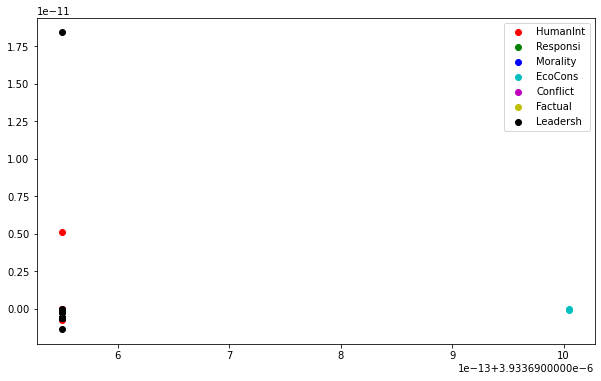

In [351]:
#print(len(X_2d))
target_ids = range(len(result.target_names))
plt.figure(figsize=(10, 6))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k'

for id, c, label in zip(target_ids, colors, result.target_names):
    plt.scatter(X_2d[y==id,0], X_2d[y==id,1], c=c, label=label)
    
plt.legend()
plt.show()

In [352]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cut_review = result_data['cut_review'].tolist()
#print(type(cut_review[0][0]))
corpus =  [str(i) for i in cut_review]
#print(type(corpus[0]))
document = []
documents = []
#document.append(corpus[0])
#print(document[0])

for l in range(len(cut_review)):
    corpus =  [str(i) for i in cut_review]
    document=[corpus[l]]
    documents.append(document)
    
ALL_FL_30= []
for document in documents:
    #print(document)
    tfidf_model = TfidfVectorizer().fit(document)
    
    # 得到语料库所有不重复的词
    feature = tfidf_model.get_feature_names()
    #print(feature)
    # 得到每个特征对应的id值：即上面数组的下标
    #print(tfidf_model.vocabulary_)
    # 每一行中的指定特征的tf-idf值：
    sparse_result = tfidf_model.transform(document)
    #print(sparse_result)
    # 每一个语料中包含的各个特征值的tf-idf值：
    # 每一行代表一个预料，每一列代表这一行代表的语料中包含这个词的tf-idf值，不包含则为空
    weight = sparse_result.toarray()
    
    # 构建词与tf-idf的字典：
    feature_TFIDF = {}
    for i in range(len(weight)):
        for j in range(len(feature)):
        # print(feature[j], weight[i][j])
            if feature[j] not in feature_TFIDF:
                feature_TFIDF[feature[j]] = weight[i][j]
            else:
                feature_TFIDF[feature[j]] = max(feature_TFIDF[feature[j]], weight[i][j])
    #print(feature_TFIDF)
    
    # 按值排序：
    #print('TF-IDF 排名前三十的：')
    featureList = sorted(feature_TFIDF.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
    featureList_30 = []
    for k in range(1, 30 if len(featureList) > 30 else len(featureList)):
        #print(featureList[k][0])
        featureList_30.append(featureList[k][0])
    #print(featureList_30)
    ALL_FL_30.append(featureList_30)
    
print(ALL_FL_30)


[['medicine', 'chinese', 'acupuncture', 'patients', 'western', 'doctors', 'traditional', 'patient', 'american', 'trust', 'people', 'needles', 'medical', 'lot', 'herbal', 'headaches', 'harvard', 'doctor', 'china', 'workers', 'weakness', 'weak', 'suffering', 'students', 'standards', 'social', 'responses', 'prescription', 'political'], ['clinic', 'clinics', 'qiao', 'people', 'ms', 'flushing', 'medical', 'chinese', 'care', 'wang', 'traditional', 'pains', 'lawsuit', 'immigrants', 'hospital', 'herbal', 'affidavit', 'western', 'unlicensed', 'truck', 'treatment', 'symptoms', 'residents', 'removal', 'patient', 'pain', 'nov', 'moved', 'massage'], ['gong', 'chinese', 'medicine', 'western', 'traditional', 'doctor', 'treated', 'spectrum', 'power', 'patients', 'medical', 'eeg', 'china', 'beijing', 'vague', 'subject', 'study', 'sept', 'experimental', 'emitted', 'drugs', 'control', 'zhi', 'yuan', 'writer', 'weight', 'wax', 'unrealistic', 'time'], ['medicine', 'qi', 'eisenberg', 'traditional', 'dr', 'c

In [353]:
'''
词云展示

'''
from wordcloud import WordCloud
import imageio
 

i = 0
for document in ALL_FL_30:    
    i = i+1
    # 3).绘制词云
    wc = WordCloud(
    background_color="white", #背景颜色
    max_words=30, #显示最大词数
    font_path="./image/simkai.ttf",  #使用字体
    min_font_size=5,# 最小字体
    max_font_size=80, # 最大字体
    width=400,  #图幅宽度
    font_step =1
    )

    wc.generate(','.join(document))
    wc.to_file('D:\\SURF\\tradition_medicine\\Data\\word_cloud\\%s.png' %(i))